<a href="https://colab.research.google.com/github/VKapitany/GAN_Introduction/blob/master/GAN_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to regular Generative Adversarial Networks

Adapted from: https://www.tensorflow.org/tutorials/generative/dcgan
and https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f

In [33]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.compat.v1.keras.backend import clear_session, get_session,set_session
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, UpSampling2D, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from keras.datasets.mnist import load_data
from tensorflow.keras import layers

import tensorflow as tf
import os
import sys
import gc
import time
import imageio
import natsort
import glob

from IPython import display

!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs.vis.embed as embed

### Data

In [ ]:
# Let's load our data (MNIST)
(train_images, train_labels), (test_images, test_labels) = load_data()
print(np.shape(train_images),np.shape(train_labels),np.shape(test_images),np.shape(test_labels))

#Reshape and normalise
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32') # Reshape
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype('float32')
test_images = (test_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

# Batch and shuffle the data
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


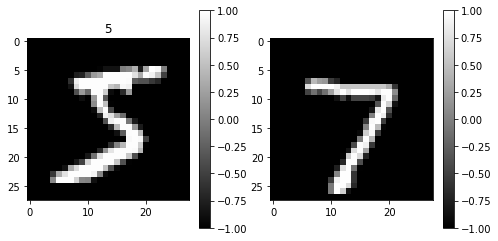

In [ ]:
# Let's see some examples 
plt.figure(1,figsize=(8,4))
plt.subplot(121)
plt.imshow(train_images[0,:,:,0],cmap='gray')
plt.title(train_labels[0])
plt.colorbar()
plt.subplot(122)
plt.imshow(test_images[0,:,:,0],cmap='gray')
plt.colorbar()


## ML

Introduction:
GANs belong to the set of algorithms named **generative models**. These algorithms belong to the field of unsupervised learning, a sub-set of ML which aims to study algorithms that learn the underlying structure of the given data, without specifying a target value. Generative models learn the **intrinsic distribution function of the input data p(x) (or p(x,y)** if there are multiple targets/classes in the dataset), allowing them to generate both synthetic inputs x’ and outputs/targets y’, typically given some hidden parameters.

<center><img src="https://raw.githubusercontent.com/VKapitany/GAN_Introduction/master/gan_overview.jpeg" width=600></center>

GAN concept:
1. you have a latent space, often a Gaussian distribution, from which you sample randomly. We will call this random sample `noise`, but really it's meant to be a condensed/latent representation of an image. This noise is the input of your `Generator`.
2. The generator transforms this noise into an image of the required size, the `generated fake samples`
3. You assign labels to these fake images, e.g. 0s, and take a batch of real image samples, to which you assign labels as well, e.g. 1s.
4. You pass on the fake and real images to the discriminator, each labelled as Fake [0] or real [1], and **train the discriminator** on these image/label pairs. The discriminator gets better at distinguishing between them.
5. Next, you take your fake samples, and assign them to be real/1s. We assign them as real because we want to train the generator to fool the discriminator. You then get the discriminator to predict the value of your fake samples (you aren't training the discriminator, just predicting the fake image samples). The loss we want the generator to optimise is the difference between the 1s and the discriminator predictions. Remember, the discriminator had been previously trained to output 0s, when it sees fake samples. 
5. So, you **backgropagate the error between your training labels (1s) and training outputs (discriminator prediction) to the generator, to train it's weights.**
6. Rinse and repeat.


In [ ]:
!mkdir gan_images
!mkdir gan_models

In [ ]:
from tensorflow.compat.v1.keras.backend import clear_session, get_session,set_session
import gc

def reset_keras():
    sess = get_session()
    clear_session()
    sess.close()
    sess = get_session()

    print(gc.collect()) # if it's done something you should see a number being outputted

    # use the same config as you used to create the session
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.per_process_gpu_memory_fraction = 1
    config.gpu_options.visible_device_list = "0"
    set_session(tf.compat.v1.Session(config=config))

###The goal of a GAN is formally to play a minimax game between the generator and discriminator:

$\min_{G}\max_{D}V(D,G) = \mathbb{E}_{x~p_{data}(x)}[log D(x)] +  \mathbb{E}_{z~p(z)}[log 1-D(G(z))]$

for:
- variable function V,
-discriminator D,
-generator G, 
-real images x 
  - sampled from the image distribution of interest, p(x),
-and latent variables z
  - sampled from the latent distribution of interest, p(z).

Note: In this sense, G and D are just functions/transormations, not compiled architectures.

Trivially, this simplifies to:

**The goal of the discriminator:**

$\max_D= \frac{1}{m}\sum_{i=1}^{m}[log(D(x^{(i))}+log(1-D(G(z^{(i)})))]$

**The goal of the generator:**

$\min_G = \frac{1}{m}\sum_{i=1}^{m}log(1-D(G(z^{(i)})))$

for input datapoints $i={1,...,m}$.



### Loss: binary crossentropy
We will use binary crossentropy as our loss function, which looks like this:

$BCE(v,y)=-\frac{1}{m}\sum_{i=1}^{m}[y_i\cdot log(v_i) + (1 - y_i)(log(1-v_i)]$

where $y_i$ are the targets and $v_i$ the outputs, and y and v the corresponding mini-batch of said  targets and outupts (sometimes, BCE is written to include a scaling factor, which I occlude as it's set to 1)

**Discriminator**

- **Loss for real inputs, and labels = 1:**
If we replace $v_i = D(x_i)$ and $y_i = 1 \forall i$, we get 
$-\frac{1}{m}\sum_{i=1}^{m}[log(D(x^{(i))}]$. This is the loss related to the real images.

- **Loss for fake inputs, and labels = 0:**
If we replace $v_i = D(G(z_i))$ and $y_i = 0 \forall i$, we get 
$-\frac{1}{m}\sum_{i=1}^{m}[log(1-D(G(z^{(i)})))]$. This is the loss related to the fake/generator made images.
- **Total discriminator loss:** average of the losses for real and fake inputs

Note that the BCE is has a negative sign. However, tensorflow minimises BCE; minimising the negative of the loss is equivalent to maximising the loss.

**Generator**

Rather than minimising $\frac{1}{m}\sum_{i=1}^{m}log(1-D(G(z^{(i)})))$, we maximise $\frac{1}{m}\sum_{i=1}^{m}log(D(G(z^{(i)})))$, as this provides stronger gradients at the start of training.

- **Loss for fake inputs, and labels = 1:**
If we replace $v_i = D(G(z_i))$ and $y_i = 1 \forall i$, we get 
$-\frac{1}{m}\sum_{i=1}^{m}[log(D(G(z^{(i)})))]$. This is the loss related to the fake/generator made images. Again, minimising this is equivalent to maximising its negative (which is our target).

In [ ]:
noise_shape = 100

#Architectures

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(noise_shape,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

generator = make_generator_model()
discriminator = make_discriminator_model()

generator.summary()
discriminator.summary()

#Losses
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#Optimizers    
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [ ]:
EPOCHS = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_shape])
# x = np.linspace(-2, 2, 8)
# y = np.linspace(-2, 2, 8)
# xv, yv = np.meshgrid(x, y)
# xv = xv.reshape(8,8,1)
# yv = yv.reshape(8,8,1)
# z = np.concatenate((xv,yv),axis=2)
# seed = z.reshape(8*8, 2)

# checkpoint_dir = 'gan_models/training_checkpoints'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_shape])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))
  plt.suptitle('Epoch {}'.format(epoch))
  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('gan_images/img{}.png'.format(epoch)) #so it's a continuous stream of images
  plt.show()

In [ ]:
gen_loss_log = []
disc_loss_log = []

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      gen_loss, disc_loss = train_step(image_batch)
      # Log the generator and discriminator losses, for analysis later
      gen_loss_log.append(gen_loss)
      disc_loss_log.append(disc_loss)
    # Produce images for the video as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 50 epochs
    if (epoch + 1) % 50 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)
      generator.save('gan_models/gen{}.h5'.format(epoch+1))
      discriminator.save('gan_models/dis{}.h5'.format(epoch+1))

    print ('Loss generator {}, loss discriminator {}'.format(gen_loss, disc_loss))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

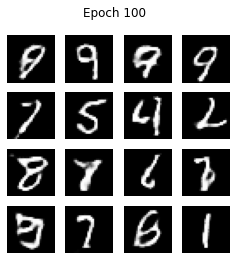

In [ ]:
reset_keras()
train(train_dataset, EPOCHS)

# For me, connected to a standard GPU runtime, this took around 11 seconds per epoch

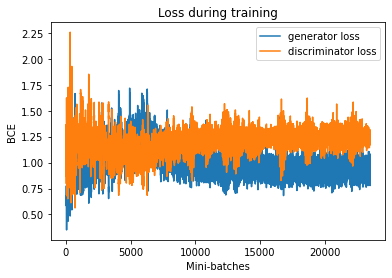

In [ ]:
# Plot history of loss during training
plt.plot(gen_loss_log, label = 'generator loss')
plt.plot(disc_loss_log, label = 'discriminator loss')
plt.legend()
plt.xlabel('Mini-batches')
plt.ylabel('BCE')
plt.title('Loss during training')
plt.savefig('training_loss.png')

The training loss that I got:

<img src='https://raw.githubusercontent.com/VKapitany/GAN_Introduction/master/training_loss.png' width=400>


In [37]:
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = natsort.natsorted(glob.glob('gan_images/img*.png'))
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


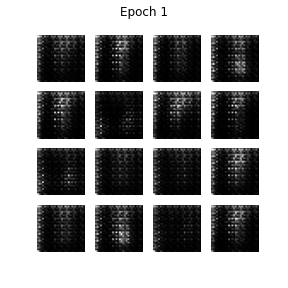

In [38]:
embed.embed_file(anim_file)

What my training looked like:

<img src="https://raw.githubusercontent.com/VKapitany/GAN_Introduction/master/gan.gif" width=300 align=center>